<a href="https://colab.research.google.com/github/dtonavitor/ponderada-gridworld/blob/main/Gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

OBS: Ponto inicial (0, 0); Ponto final (7, 7)

Na classe Grid temos o método "step". Ele funciona tanto para a lógica do agente quanto para a recompensa. Nele o agente pondera para qual estado cada ação que ele pode tomar o levará e qual será sua recompensa (essas informações serão utilizadas para calcular o valor esperado). As recompensas foram decididas da seguinte forma:

- Chegar no ponto final: recompensa de 10
- Cada ação tomada para um novo estado: recompensa de -0.05 (a punição incentiva a busca pelo menor caminho)
- Tomar uma ação e permanecer no mesmo estado (bordas do grid): recompensa de -0.5
- Cair em uma montanha: recompensa de -3
- Cair em uma areia movediça: recompensa de -10

In [ ]:
class Grid:
    """
        Classe que representa o ambiente de jogo.
        Atributos:
            grid: matriz que representa o ambiente.
            montanhas_posicao: lista com as posições das montanhas.
            areias_posicao: lista com as posições das areias.
    """
    def __init__(self, montanhas=3, areias=3):
        """
        Inicializa o ambiente randomizando as posições das montanhas e areias de acordo com os parâmetros.
        Args:
            montanhas (int, opicional): número de montanhas a serem adicionadas no grid. Padrão com 3.
            areias (int, opicional): número de areias movediças a serem adicionadas no grid. Padrão com 3.
        Returns:
            None
        """
        self.grid = np.zeros((8, 8))
        self.montanhas_posicao = []
        self.areias_posicao = []

        qtd_montanhas = 0
        while qtd_montanhas < montanhas:
            x = random.randint(0, 7)
            y = random.randint(0, 7)
            posicao = (x, y)
            # Verifica se a posição já não foi ocupada por uma montanha ou se é a posição inicial ou final
            if self.grid[x][y] == 0 and posicao != (0, 0) and posicao != (7, 7):
                self.grid[x][y] = 4
                self.montanhas_posicao.append(posicao)
                qtd_montanhas += 1

        qtd_areias = 0
        while qtd_areias < areias:
            x = random.randint(0, 7)
            y = random.randint(0, 7)
            posicao = (x, y)
            if self.grid[x][y] == 0 and posicao != (0, 0) and posicao != (7, 7):
                self.grid[x][y] = -8
                self.areias_posicao.append((x, y))
                qtd_areias += 1

        self.grid[0][0] = 20
        self.grid[7][7] = 20

        self.reset()
        return

    def reset(self):
        """
        Reinicia o ambiente, zerando os valores dos estados.
        """
        self.valores = np.zeros((8, 8))
        return

    def step(self, estado, acao):
        """
        Executa uma ação em um estado do ambiente.
        Retorna o próximo estado e a recompensa associada.
        Args:
            estado (tuple): tupla com as coordenadas do estado atual.
            acao (tuple): ação a ser executada.

        Returns:
            prox_estado (tuple): coordenadas do próximo estado.
            recompensa (float): recompensa associada à ação.
        """
        if estado == (7, 7):
            return estado, 10

        if estado in self.areias_posicao:
            return estado, -10

        if estado in self.montanhas_posicao:
            return estado, -3

        recompensa = -0.05

        prox_estado = ()

        if acao == (-1, 0):
            prox_estado = (estado[0] - 1, estado[1])
        elif acao == (1, 0):
            prox_estado = (estado[0] + 1, estado[1])
        elif acao == (0, 1):
            prox_estado = (estado[0], estado[1] + 1)
        elif acao == (0, -1):
            prox_estado = (estado[0], estado[1] - 1)

        if prox_estado[0] < 0 or prox_estado[0] > 7:
            prox_estado = estado
            recompensa = -0.5
        elif prox_estado[1] < 0 or prox_estado[1] > 7:
            prox_estado = estado
            recompensa = -0.5

        return prox_estado, recompensa

    def valor_esperado(self, estado, politica, desconto):
        """ Calcula o valor esperado de um estado de acordo com uma política.
            Utiliza a equação de Bellman para calcular o valor esperado. -> V(s) = Σπ(a|s) * ΣP(s'|s, a) * (R(s, a, s') + γV(s'))

        Args:
            estado (tuple): coordenadas do estado atual.
            politica (list): política a ser seguida, que indica a probabilidade de escolha de cada ação.
            desconto (float): fator de desconto.

        Returns:
            valor (float): valor esperado do estado.
        """
        valor = 0
        acoes = obter_acoes()
        for i in range(len(acoes)):
            prox_estado, recompensa = self.step(estado, acoes[i])
            if estado == prox_estado:
                valor += politica[i] * (recompensa + (desconto * 0))
            else:
                valor += politica[i] * (recompensa + (desconto * self.valores[prox_estado]))
        return valor

    def visualizar_grid(self):
        """ Gera uma visualização do grid do ambiente utilizando matplotlib.
            Branco: areia movediça.
            Verde: caminho livre.
            Marrom: montanha.
        """
        cmap = mcolors.ListedColormap(['white', 'green', 'saddlebrown', 'blue'])
        bounds = [-9, -7, 3, 5, 25]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)

        fig, ax = plt.subplots()
        ax.imshow(self.grid, cmap=cmap, norm=norm)

        ax.set_xticks(np.arange(-.5, 8, 1), minor=True)
        ax.set_yticks(np.arange(-.5, 8, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
        ax.tick_params(which='minor', size=0)

        for i in range(8):
            for j in range(8):
                if self.grid[i, j] == 4:
                    ax.text(j, i, 'Montanha', ha='center', va='center', color='white')
                elif self.grid[i, j] == -8:
                    ax.text(j, i, 'Areia', ha='center', va='center', color='black')
                elif  i == 0 and j == 0:
                    ax.text(j, i, 'Início', ha='center', va='center', color='white')
                elif i == 7 and j == 7:
                    ax.text(j, i, 'Chegada', ha='center', va='center', color='white')

        plt.show()

In [ ]:
def obter_acoes():
    """ Retorna uma lista com as ações possíveis.
        0 - cima
        1 - baixo
        2 - direita
        3 - esquerda

    Returns:
        acoes (list): lista com as ações possíveis.
    """

    acoes = [(-1, 0), (1, 0), (0, 1), (0, -1)]
    return acoes

In [ ]:
def obter_politicas():
    """ Retorna uma lista com as políticas iniciais para cada estado.
        Inicialmente, todas as ações possuem a mesma probabilidade de serem escolhidas (25%).

    Returns:
        politicas (list): lista com as políticas iniciais.
    """
    politicas = []
    for i in range(8):
        politica = []
        for j in range(8):
            politica.append([0.25, 0.25, 0.25, 0.25])
        politicas.append(politica)
    return politicas

In [ ]:
def avaliacao_iterativa(env, politicas, theta, desconto):
    """ Avaliação iterativa de uma politica.

    Args:
        env (object): objeto da classe Grid que representa o ambiente do jogo.
        politicas (list): lista com as políticas a serem avaliadas.
        theta (float): valor de theta para a avaliação iterativa. Indica quando a estimativa de valor de um estado está próxima do valor real.
        desconto (float): fator de desconto.

    Returns:
        valores (list): lista com os valores dos estados de acordo com a política após a avaliação.
    """
    delta = theta + 1
    while(delta > theta):
        delta = 0
        for x in range(8):
            for y in range(8):
                estado = (x, y)
                valor = env.valores[x][y]
                valor_esperado = env.valor_esperado(estado, politicas[x][y], desconto)
                env.valores[x][y] = valor_esperado
                delta = max(delta, abs(valor - env.valores[x][y]))

    return env.valores

In [ ]:
def obter_melhor_valor(grid, estado, desconto):
    """ Retorna o melhor valor e a melhor ação para um estado.
        Utiliza a equação de Bellman para calcular o melhor valor. -> V(s) = ΣP(s'|s, a) * (R(s, a, s') + γV(s'))

    Args:
        env (object): objeto da classe Grid que representa o ambiente do jogo.
        estado (tuple): coordenadas do estado atual.
        desconto (float): fator de desconto.

    Returns:
        melhor_acao (int): melhor ação a ser tomada (0 - cima, 1 - baixo, 2 - direita, 3 - esquerda).
    """
    melhor_valor = -np.Infinity
    melhor_acao = None
    acoes = obter_acoes()
    for i in range(len(acoes)):
        prox_estado, recompensa = env.step(estado, acoes[i])
        if estado == prox_estado:
            valor = recompensa + (desconto * 0)
        else:
            valor = recompensa + (desconto * env.valores[prox_estado])
        if valor > melhor_valor:
            melhor_valor = valor
            melhor_acao = i
    return melhor_acao

In [ ]:
def melhorar_politica(env, politica):
    """ Método para encontrar a melhor política para um ambiente (Policy Iteration).
        π(s) = argmax ΣP(s'|s, a) * (R(s, a, s') + γV(s'))

    Args:
        env (object): objeto da classe Grid que representa o ambiente do jogo.
        politica (list): política a ser melhorada.

    Returns:
        valores (list): lista com os valores dos estados de acordo com a política após a avaliação.
        politica (list): política melhorada.
    """
    while True:
        valores = avaliacao_iterativa(env, politica, 0.0001, 0.9)
        politica_estavel = True
        for x in range(8):
            for y in range(8):
                estado = (x, y)
                acao_antiga =  np.argmax(politica[x][y])
                melhor_acao = obter_melhor_valor(env, estado, 0.9)
                if acao_antiga != melhor_acao:
                    politica_estavel = False
                politica[x][y] = np.eye(4)[melhor_acao]
        if politica_estavel:
            return valores, politica

In [ ]:
def obter_trajeto(env, valores, politicas):
    """ Calcula o trajeto a ser seguido pelo agente de acordo com a política e os valores dos estados.

    Args:
        env (object): objeto da classe Grid que representa o ambiente do jogo.
        valores (list): valores de cada estado de acordo com a política.
        politicas (list): política a ser seguida.

    Returns:
        trajeto (list): lista com as coordenadas do trajeto a ser seguido.
        passos (int): quantidade de passos realizados.
        fim_de_jogo (int): indica se o jogo terminou. -1 para fim de jogo, 0 para jogo não terminado.
    """
    passos = 0

    trajeto = [(0, 0)]

    while True:
        x, y = trajeto[-1]

        acoes = obter_acoes()
        melhor_acao = None
        melhor_valor = -np.Infinity

        for i in range(len(acoes)):
            # Garante que o agente pode executar a ação.
            if politicas[x][y][i] != 0:
                dx, dy = acoes[i][0], acoes[i][1]
                novo_x, novo_y = x + dx, y + dy
                # Garante que o novo estado não seja um estado de montanha ou fora do grid.
                if 0 <= novo_x < 8 and 0 <= novo_y < 8 and (novo_x, novo_y) not in trajeto and (novo_x, novo_y) not in env.montanhas_posicao:
                    valor_vizinho = valores[novo_x, novo_y]
                    if valor_vizinho > melhor_valor:
                        melhor_valor = valor_vizinho
                        melhor_acao = (novo_x, novo_y)

        # O jogo acabou se o agente caiu em uma areia movediça.
        if melhor_acao in env.areias_posicao:
            return trajeto, passos, -1

        if melhor_acao:
            trajeto.append(melhor_acao)
            passos += 1
        else:
            return trajeto, passos, -1

        # O jogo terminou quando o jogador chega no estado (7, 7) ou passa 500 passos. Ganha se chegar em (7, 7).
        if passos == 500 or (7, 7) in trajeto:
            if passos == 500:
                return trajeto, passos, -1
            break
    return trajeto, passos, 0

In [ ]:
def visualizar_trajeto(grid):
    """ Gera uma visualização da rota no grid do ambiente utilizando matplotlib.

    Args:
        grid (list): lista que representa o grid do ambiente.

    """
    cmap = mcolors.ListedColormap(['white', 'green', 'saddlebrown', 'red'])
    bounds = [-9, -7, 3, 5, 10]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=cmap, norm=norm)

    ax.set_xticks(np.arange(-.5, 8, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 8, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', size=0)

    for i in range(8):
        for j in range(8):
            if grid[i, j] == 4:
                ax.text(j, i, 'Montanha', ha='center', va='center', color='white')
            elif grid[i, j] == -8:
                ax.text(j, i, 'Areia', ha='center', va='center', color='black')

    plt.show()


--Grid--


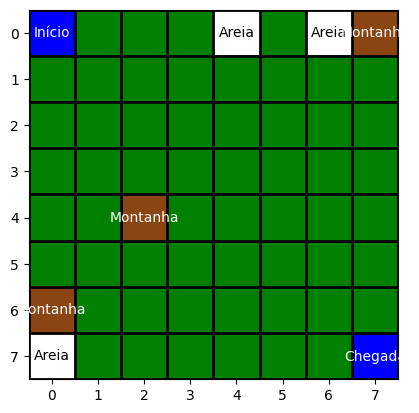

-- Valores Esperados (Política Inicial) --
[[ -0.61121453  -0.82419093  -1.40301608  -3.27139242 -10.
   -5.46354388 -10.          -3.        ]
 [ -0.67022095  -0.92676339  -1.41794428  -2.41435231  -4.12189726
   -3.56022806  -3.98268391  -2.00684968]
 [ -0.71870144  -0.98453237  -1.33576716  -1.69711541  -2.12283009
   -2.03294727  -1.91154934  -1.21443629]
 [ -0.81736642  -1.17237174  -1.61504567  -1.4476719   -1.36070631
   -1.21855212  -1.04351842  -0.75688346]
 [ -1.01951048  -1.5714398   -3.          -1.53908458  -1.0363769
   -0.75644299  -0.52868029  -0.3837575 ]
 [ -1.42015616  -1.57008449  -1.65020044  -1.13415852  -0.72771265
   -0.35617323   0.05623105   0.30219175]
 [ -3.          -2.1141535   -1.4077888   -0.90151904  -0.48537855
    0.06713227   1.05478776   2.39282039]
 [-10.          -3.19615472  -1.36876089  -0.75722153  -0.37293235
    0.3073408    2.39397893  10.        ]]


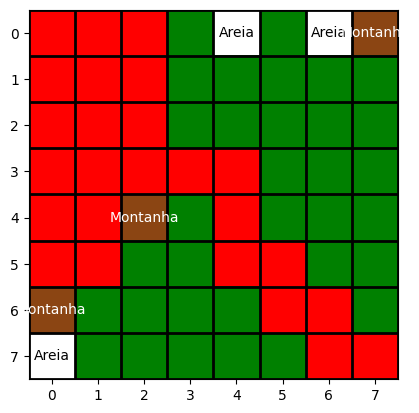

Passos da primeira política: 24


-- Nova Política --
[array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([1., 0., 0., 0.]), array([0., 1., 0., 0.]), array([1., 0., 0., 0.]), array([1., 0., 0., 0.])]
[array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.])]
[array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.])]
[array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 0., 1., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.])]
[array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([1., 0., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0

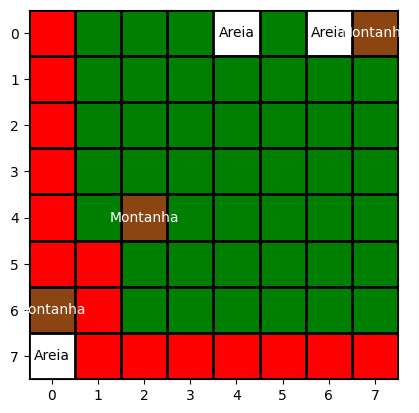

Passos da segunda política: 14


In [ ]:
"""
Código principal que inicializa o grid, calcula os valores e melhora a política.
"""
# inicializa o ambiente e imprime o grid gerado
env = Grid()
print("--Grid--")
env.visualizar_grid()

# calcula os valores esperados para a política inicial
politicas_1 = obter_politicas()
valores_1 = avaliacao_iterativa(env, politicas_1, 0.0001, 0.9)

print("-- Valores Esperados (Política Inicial) --")
print(valores_1)

# calcula o trajeto para a política inicial
trajeto_1, passos_1, fim_de_jogo = obter_trajeto(env, valores_1, politicas_1)
grid_visualizacao_1 = np.copy(env.grid)
for posicao in trajeto_1:
    grid_visualizacao_1[posicao[0]][posicao[1]] = 10

visualizar_trajeto(grid_visualizacao_1)

print(f"Passos da primeira política: {passos_1}")

if fim_de_jogo == -1:
    print("Fim de jogo")


env.reset()
# melhora a política
politicas_novas = politicas_1.copy()
valores_novos, politicas_novas = melhorar_politica(env, politicas_novas)
print("\n")

print("-- Nova Política --")
for i in range(8):
    print(politicas_novas[i])

print("\n")
print("-- Valores Esperados (Política Melhorada) --")
print(valores_novos)

# calcula a rota da política melhorada
grid_visualizacao_2 = np.copy(env.grid)
trajeto_2, passos_2, fim_de_jogo = obter_trajeto(env, valores_novos, politicas_novas)

for posicao in trajeto_2:
    grid_visualizacao_2[posicao[0]][posicao[1]] = 10

visualizar_trajeto(grid_visualizacao_2)

print(f"Passos da segunda política: {passos_2}")

if fim_de_jogo == -1:
    print("Fim de jogo")

##Comparação das políticas

A segunda política foi calculada utilizando o método de Policy Iteration para encontrar a melhor política. Para comprovar que foi encontrada uma política melhor do que a inicial, foi decidido fazer um teste rodando múltiplas vezes cada experimento e calculando a porcentagem de acertos para cada política, alterando a quantidade de montanhas de 0 a 10. Para cada quantidade de montanhas foram gerados 100 resultados para cada política, que podem ser visualizados no gráfico abaixo.

0
1
2
3
4
5
6
7
8
9
10


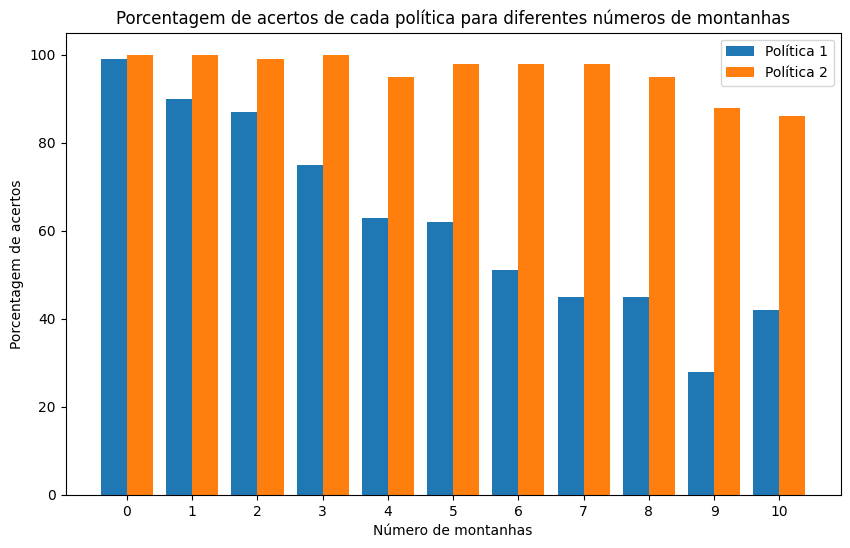

In [ ]:
episodios = 100
qtd_montanhas = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

acertos_politica_1 = []
acertos_politica_2 = []

for j in range(len(qtd_montanhas)):
  print(j)
  finalizacao_1 = episodios
  finalizacao_2 = episodios
  for i in range(episodios):
    env = Grid(qtd_montanhas[j])

    politicas = obter_politicas()
    valores_1 = avaliacao_iterativa(env, politicas, 0.0001, 0.9)

    trajeto_1, passos_1, fim_de_jogo = obter_trajeto(env, valores_1, politicas)

    grid_visualizacao_1 = np.copy(env.grid)
    for posicao in trajeto_1:
      grid_visualizacao_1[posicao[0]][posicao[1]] = 10

    if fim_de_jogo == -1:
      finalizacao_1 -= 1

    env.reset()

    politicas_novas = politicas_1.copy()
    valores_novos, politicas_novas = melhorar_politica(env, politicas_novas)

    grid_visualizacao_2 = np.copy(env.grid)
    trajeto_2, passos_2, fim_de_jogo = obter_trajeto(env, valores_novos, politicas_novas)

    for posicao in trajeto_2:
      grid_visualizacao_2[posicao[0]][posicao[1]] = 10

    if fim_de_jogo == -1:
      finalizacao_2 -= 1
  acertos_politica_1.append((finalizacao_1 / episodios) * 100)
  acertos_politica_2.append((finalizacao_2 / episodios) * 100)

plt.figure(figsize=(10, 6))
qtd_montanhas = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

X_axis = np.arange(len(qtd_montanhas))

plt.bar(X_axis - 0.2, acertos_politica_1, 0.4, label = 'Política 1')
plt.bar(X_axis + 0.2, acertos_politica_2, 0.4, label = 'Política 2')
plt.xticks(X_axis, qtd_montanhas)
plt.xlabel("Número de montanhas")
plt.ylabel("Porcentagem de acertos")
plt.title("Porcentagem de acertos de cada política para diferentes números de montanhas")
plt.legend()
plt.show()

É possível perceber que a política inicial foi melhorada substancialmente, considerando que a taxa de acertos se manteve acima dos 80% mesmo com 10 montanhas, enquanto que a política inicial foi decrescendo com mais montanhas.